# About

`SBROD` is a method for single-model (Smooth Backbone-Reliant Orientation-Dependent) protein quality assessment.

# Use cases

Here we introduce various applications and typical use cases for `SBROD`.

## Rank protein models

The main purpose of `SBROD` is the ranking of predicted protein structures.

### Standalone application

`SBROD` is freely available for download at https://drive.google.com/drive/folders/0B3zcrZZIqs3fTGx6RVI3ZnVtNUU.

First, we download its standalone executable.

In [1]:
!mkdir -p data
%cd data

/Users/mike/sbrod/tutorial/data


In [2]:
# linux
# !../gdrive_download.sh "https://drive.google.com/open?id=0B3zcrZZIqs3fcE9pSWRWRGpCdmc"
# MacOS
!../gdrive_download.sh "https://drive.google.com/open?id=0B3zcrZZIqs3fODhGUTU0dFVrTjA"

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100   383    0   383    0     0     85      0 --:--:--  0:00:04 --:--:--    85
100 45.2M    0 45.2M    0     0  3725k      0 --:--:--  0:00:12 --:--:-- 6609k
curl: Saved to filename 'macos.zip'


Let's unzip the executables.

In [3]:
!unzip -o *.zip

Archive:  macos.zip
  inflating: README                  
   creating: base/
  inflating: base/pipeline.pkl       
  inflating: base/Rotamers           
  inflating: sbrod                   


Now we are ready to assess protein models, but first, we must have some protein structures to rank.

Let's download predicted domains `T0866-D1` from the `CASP12` experiment.

In [4]:
decoy_set = 'T0866-D1'
!wget http://predictioncenter.org/download_area/CASP12/predictions_trimmed_to_domains/{decoy_set}.tar.gz
!tar -xf {decoy_set}.tar.gz
!ls {decoy_set} | wc

--2018-05-19 20:19:51--  http://predictioncenter.org/download_area/CASP12/predictions_trimmed_to_domains/T0866-D1.tar.gz
Resolving predictioncenter.org (predictioncenter.org)... 128.120.136.187
Connecting to predictioncenter.org (predictioncenter.org)|128.120.136.187|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 7165886 (6.8M) [application/x-gzip]
Saving to: ‘T0866-D1.tar.gz’

T0866-D1.tar.gz     100%[===================>]   6.83M  2.01MB/s    in 3.4s    

2018-05-19 20:19:55 (2.01 MB/s) - ‘T0866-D1.tar.gz’ saved [7165886/7165886]

     504     504    8064


Now, we are going to assess the quality of downloaded protein structures.

The SBROD scores can be considered only as relative scores. That is, the SBROD scores can be used to compare different protein models with same amino acid sequences to select protein models with the highest SBROD scores.

Note that in general, SBROD scores do not show any relations between protein structures with different sequences, and therefore native structures.

In [5]:
!./sbrod T0866-D1/* > scores.txt
!head -10 scores.txt

T0866-D1/T0866TS001_1-D1	1.2496446336272236
T0866-D1/T0866TS001_2-D1	1.460282546088654
T0866-D1/T0866TS001_3-D1	1.5295647006812156
T0866-D1/T0866TS001_4-D1	1.442941733872698
T0866-D1/T0866TS001_5-D1	1.8361990476328498
T0866-D1/T0866TS004_1-D1	1.4714568872468246
T0866-D1/T0866TS004_2-D1	1.5938218223622207
T0866-D1/T0866TS004_3-D1	1.4857605225081942
T0866-D1/T0866TS004_4-D1	1.5734461364025227
T0866-D1/T0866TS004_5-D1	1.5428455942179706


In [6]:
import numpy as np
import scipy
import pandas as pd
from matplotlib import pyplot as plt
from IPython.display import set_matplotlib_formats
set_matplotlib_formats('png', 'pdf')
import joblib
from IPython.utils import io

%matplotlib inline
%load_ext autoreload
%autoreload 2

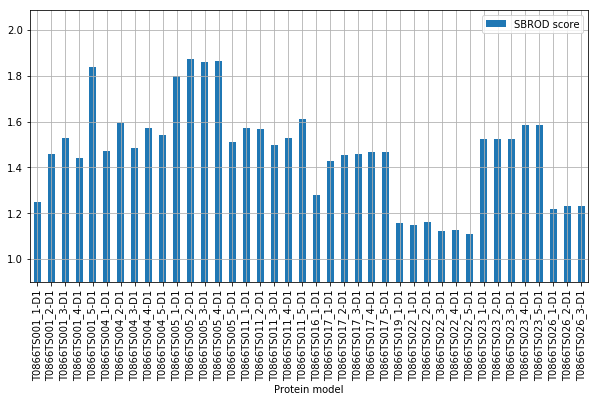

In [7]:
plt.figure()
ax = plt.gca()
predicted_scores = pd.read_csv('scores.txt', sep='\t', names=['Protein model', 'SBROD score'])
predicted_scores['Protein model'] = predicted_scores['Protein model'].apply(lambda x: x.split('/')[1])
df = predicted_scores.iloc[:40]
df.plot(kind='bar', figsize=(10, 5), x='Protein model', ax=ax)
plt.grid()
plt.ylim([df['SBROD score'].min() - df['SBROD score'].std(),
          df['SBROD score'].max() + df['SBROD score'].std()])
plt.show()

Let's compare the predicted scores with the ground-truth GDT-TS, a distance between predicted protein models and their corresponding native protein structures.

In [8]:
ground_truth = pd.read_table(
    'http://predictioncenter.org/download_area/CASP12/results_LGA_sda/{}.SUMMARY.lga_sda.txt'.format(decoy_set),
    delim_whitespace=True
)
ground_truth.NAME = ground_truth.NAME.apply(lambda x: x.split('.')[0])

In [9]:
df = predicted_scores
df = df.merge(ground_truth, left_on='Protein model', right_on='NAME')

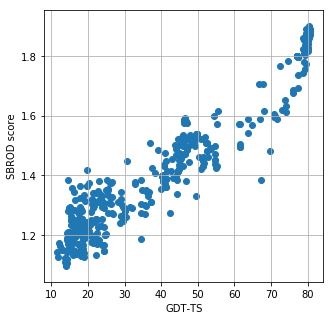

In [10]:
plt.figure(figsize=(5, 5))
plt.scatter(df['GDT_TS'], df['SBROD score'])
plt.xlabel('GDT-TS')
plt.ylabel('SBROD score')
plt.grid()
plt.show()

One can notice, that quality of `SBROD` scores is suspiciously high in this figure.

Indeed, the default predictive model included in `SBROD` was trained on a dataset including the `CASP12` data.

For a more fare evaluation, below we change the predictive model to one that was trained without `CASP12` data.

#### Load different predictive models

Here we are going to change the predictive model used in `SBROD`.

We replace the default predictive model `base/pipeline.pkl` with a pipeline trained on the `CASP[5-11]` dataset with decoy protein models generated with the `NMA` technique.

In [11]:
# download the pipeline
!../gdrive_download.sh "https://drive.google.com/open?id=0B3zcrZZIqs3fNU5pMXYxSHVjRVE"

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100   383    0   383    0     0     54      0 --:--:--  0:00:06 --:--:--    80
100 35.2M    0 35.2M    0     0  2753k      0 --:--:--  0:00:13 --:--:-- 6425k
curl: Saved to filename 'pipeline.pkl'


Replace the predictive model in `./base` directory

In [12]:
!mv pipeline.pkl base

Now, let's score the protein models again.

In [13]:
!./sbrod T0866-D1/* > scores.txt
!head -10 scores.txt

T0866-D1/T0866TS001_1-D1	1.2939483439269082
T0866-D1/T0866TS001_2-D1	1.3945409625703136
T0866-D1/T0866TS001_3-D1	1.4492892708866845
T0866-D1/T0866TS001_4-D1	1.380506897337007
T0866-D1/T0866TS001_5-D1	1.507876519245482
T0866-D1/T0866TS004_1-D1	1.434141122939799
T0866-D1/T0866TS004_2-D1	1.477021038595789
T0866-D1/T0866TS004_3-D1	1.4468173198572796
T0866-D1/T0866TS004_4-D1	1.503146397713076
T0866-D1/T0866TS004_5-D1	1.475760810856152


In [14]:
predicted_scores = pd.read_csv('scores.txt', sep='\t', names=['Protein model', 'SBROD score'])
predicted_scores['Protein model'] = predicted_scores['Protein model'].apply(lambda x: x.split('/')[1])
df = predicted_scores.merge(ground_truth, left_on='Protein model', right_on='NAME')

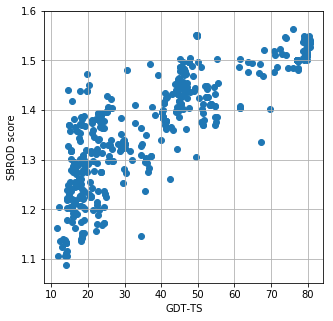

In [15]:
plt.figure(figsize=(5, 5))
plt.scatter(df['GDT_TS'], df['SBROD score'])
plt.xlabel('GDT-TS')
plt.ylabel('SBROD score')
plt.grid()
plt.show()

### Interactive web server

We can also score protein models using web server http://www.karasikov.com/proteins, which is very intuitive and self-explanatory.

## Train a custom predictive model

Here we show how to train a custom predictive model on different data.

A typical framework for training a new predictive models looks as follows:
1. Get training data
2. Extract features from the training data (kind of data preprocessing)
3. Train a new predictive model `pipeline.pkl`
4. Replace the default predictive model `pipeline.pkl` with the trained one

For the sake of simplicity, we are going to train a new predictive model on the same `T0866-D1` dataset, which we have downloaded above.

### Prepare a training set and the feature extractor

`SBROD` calls program `Rotamers` for feature extraction.

The program `Rotamers` was written in `C++` for high efficiency and used for modeling spacial protein structures and various other tasks. Its standalone binary executables are provided with `SBROD`.

In [16]:
%cd ..
!mkdir -p training
%cd training

/Users/mike/sbrod/tutorial
/Users/mike/sbrod/tutorial/training


In [17]:
!cp ../data/base/Rotamers ../../protein_scoring/scripts/

Copy the training set.

In [18]:
!mkdir training_set
!cp -r ../data/T0866-D1 ./training_set

We also have to provide ground-truth scores along with the training set.

In [19]:
ground_truth = pd.read_table(
    'http://predictioncenter.org/download_area/CASP12/results_LGA_sda/T0866-D1.SUMMARY.lga_sda.txt',
    delim_whitespace=True
)
ground_truth.NAME = ground_truth.NAME.apply(lambda x: x.split('.')[0])

In [20]:
ground_truth.rename(columns={'GDT_TS': 'GDT-TS-score'}).to_csv('./training_set/T0866-D1/scores.txt', sep='\t')

In [21]:
!ls training_set

T0866-D1


In [22]:
!ls training_set/T0866-D1/ | tail

T0866TS486_3-D1
T0866TS486_4-D1
T0866TS486_5-D1
T0866TS489_1-D1
T0866TS498_1-D1
T0866TS498_2-D1
T0866TS498_3-D1
T0866TS498_4-D1
T0866TS498_5-D1
scores.txt


### Extract features

Use script `generate_dataset.sh` for feature extraction with the default parameters.

In [23]:
!../../protein_scoring/scripts/generate_dataset.sh 4 ./training_set > /dev/null

In [24]:
!ls -lh binaries

total 16168
-rw-r--r--  1 mike  staff    64K May 19 20:29 *backboneatom-b25-c7-n0--residue_type_dependent--skip_errors.mat25cb53489019212e1beb4c01fdec88f5.csv
-rw-r--r--  1 mike  staff   4.5M May 19 20:29 *backboneatom-b25-c7-n0--residue_type_dependent--skip_errors.mat25cb53489019212e1beb4c01fdec88f5.npz
-rw-r--r--  1 mike  staff    64K May 19 20:28 *hbonds-b6-a6-c6-n2--skip_errors.mat25cb53489019212e1beb4c01fdec88f5.csv
-rw-r--r--  1 mike  staff    33K May 19 20:28 *hbonds-b6-a6-c6-n2--skip_errors.mat25cb53489019212e1beb4c01fdec88f5.npz
-rw-r--r--  1 mike  staff    64K May 19 20:28 *residues-d4-b10-a12-c5-n0--skip_errors.mat25cb53489019212e1beb4c01fdec88f5.csv
-rw-r--r--  1 mike  staff   1.8M May 19 20:28 *residues-d4-b10-a12-c5-n0--skip_errors.mat25cb53489019212e1beb4c01fdec88f5.npz
-rw-r--r--  1 mike  staff    64K May 19 20:29 *solvation-b3-a2-c15--skip_errors.mat25cb53489019212e1beb4c01fdec88f5.csv
-rw-r--r--  1 mike  staff   279K May 19 20:29 *solvation-b3-a2-c15--skip_errors.mat2

### Train predictive model

In [25]:
import joblib
from sklearn.preprocessing import Normalizer, MaxAbsScaler
import sys, os
sys.path.append(os.path.abspath('../../protein_scoring'))
from data_mining import *

First, load the extracted features

In [26]:
residues_normalizer = Normalizer()
hbonds_normalizer = MaxAbsScaler()
solvation_normalizer = MaxAbsScaler()
backboneatom_normalizer = Normalizer()

CASP = [
    ('*residues-d4-b10-a12-c5-n0--skip_errors.mat',
     '25cb53489019212e1beb4c01fdec88f5',
     lambda X: residues_normalizer.fit_transform(X),
     lambda X: residues_normalizer.transform(X)),
    ('*hbonds-b6-a6-c6-n2--skip_errors.mat',
     '25cb53489019212e1beb4c01fdec88f5',
     lambda X: hbonds_normalizer.fit_transform(X),
     lambda X: hbonds_normalizer.transform(X)),
    ('*solvation-b3-a2-c15--skip_errors.mat',
     '25cb53489019212e1beb4c01fdec88f5',
     lambda X: solvation_normalizer.fit_transform(X),
     lambda X: solvation_normalizer.transform(X)),
    ('*backboneatom-b25-c7-n0--residue_type_dependent--skip_errors.mat',
     '25cb53489019212e1beb4c01fdec88f5',
     lambda X: backboneatom_normalizer.fit_transform(X),
     lambda X: backboneatom_normalizer.transform(X)),
]

In [27]:
X, scores = get_dataset([(pattern, checksum, fit_transform)
                         for (pattern, checksum, fit_transform, transform) in CASP],
                        '.*')

Shape of the first dataset:  (504, 4371840)
Shape of the second dataset: (504, 216)
Shape of the final dataset:  (504, 4372056)
Shape of the first dataset:  (504, 4372056)
Shape of the second dataset: (504, 138)
Shape of the final dataset:  (504, 4372194)
Shape of the first dataset:  (504, 4372194)
Shape of the second dataset: (504, 239775)
Shape of the final dataset:  (504, 4611969)


In [28]:
X.shape

(504, 4611969)

Now we have 504 protein models, from which we extracted per 4,611,969 sparse features to train on.

In [29]:
%%time

model = RRModel(normalize=False, fit_intercept=False, solver='sparse_cg', alpha=5)

model.fit(X, scores)

CPU times: user 663 ms, sys: 180 ms, total: 842 ms
Wall time: 675 ms


In [30]:
joblib.dump(
    Pipeline([('scaler', CombinedScaler([residues_normalizer, hbonds_normalizer,
                                         solvation_normalizer, backboneatom_normalizer])),
              ('scorer', model)]),
    'pipeline.pkl', protocol=2
)

['pipeline.pkl']

### Change trained model

In [31]:
!mv pipeline.pkl ../data/base
%cd ../data

/Users/mike/sbrod/tutorial/data


In [32]:
ls -lh base/

total 73408
-rwxr-xr-x  1 mike  staff   661K Mar  9  2017 Rotamers*
-rw-r--r--  1 mike  staff    35M May 19 20:29 pipeline.pkl


### Test

Let's check if the performance now is perfect on the training set.

In [33]:
!./sbrod ../training/training_set/*/*[!txt] > scores_retrained.txt

In [34]:
predicted_scores = pd.read_csv('scores_retrained.txt', sep='\t', names=['Protein model', 'SBROD score'])
predicted_scores['Protein model'] = predicted_scores['Protein model'].apply(lambda x: x.split('/')[-1])

In [35]:
ground_truth = pd.read_table(
    'http://predictioncenter.org/download_area/CASP12/results_LGA_sda/{}.SUMMARY.lga_sda.txt'.format(decoy_set),
    delim_whitespace=True
)
ground_truth.NAME = ground_truth.NAME.apply(lambda x: x.split('.')[0])

In [36]:
df = predicted_scores
df = df.merge(ground_truth, left_on='Protein model', right_on='NAME')

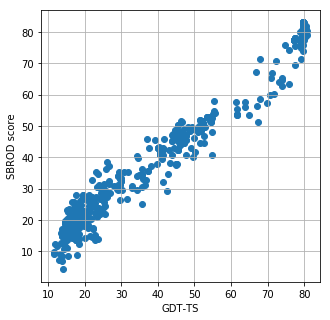

In [37]:
plt.figure(figsize=(5, 5))
plt.scatter(df['GDT_TS'], df['SBROD score'])
plt.xlabel('GDT-TS')
plt.ylabel('SBROD score')
plt.grid()
plt.show()

The correlation of the SBROD scores with ground-truth is almost perfect, but these are results from testing on the same dataset that was used for training.

## Augment training data with NMA

Here show how one can enlarge a training dataset using the [NOLB tool](https://team.inria.fr/nano-d/software/nolb-normal-modes/) (c) Alexandre Hoffmann & Sergei Grudinin.

First, let's download the `NOLB` tool.

In [38]:
#!wget --no-check-certificate https://files.inria.fr/NanoDFiles/Website/Software/NOLB/Linux/NOLB
!wget --no-check-certificate https://files.inria.fr/NanoDFiles/Website/Software/NOLB/MacOS/NOLB

--2018-05-19 20:32:48--  https://files.inria.fr/NanoDFiles/Website/Software/NOLB/MacOS/NOLB
Resolving files.inria.fr (files.inria.fr)... 128.93.162.87
Connecting to files.inria.fr (files.inria.fr)|128.93.162.87|:443... connected.
  Unable to locally verify the issuer's authority.
HTTP request sent, awaiting response... 200 OK
Length: 1538352 (1.5M) [text/plain]
Saving to: ‘NOLB’

NOLB                100%[===================>]   1.47M  5.76MB/s    in 0.3s    

2018-05-19 20:32:49 (5.76 MB/s) - ‘NOLB’ saved [1538352/1538352]



In [39]:
!chmod 755 NOLB

Then, let's download the CASP11 target structures

In [40]:
!wget http://predictioncenter.org/download_area/CASP11/targets/casp11.targets_unsplitted.release11242014.tgz

--2018-05-19 20:32:49--  http://predictioncenter.org/download_area/CASP11/targets/casp11.targets_unsplitted.release11242014.tgz
Resolving predictioncenter.org (predictioncenter.org)... 128.120.136.187
Connecting to predictioncenter.org (predictioncenter.org)|128.120.136.187|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 3488965 (3.3M) [application/x-tar]
Saving to: ‘casp11.targets_unsplitted.release11242014.tgz’

casp11.targets_unsp 100%[===================>]   3.33M  1.17MB/s    in 2.9s    

2018-05-19 20:32:52 (1.17 MB/s) - ‘casp11.targets_unsplitted.release11242014.tgz’ saved [3488965/3488965]



In [41]:
!mkdir -p casp11_targets && tar -xf casp11.targets_unsplitted.release11242014.tgz -C casp11_targets

In [42]:
!ls casp11_targets/

T0759.pdb T0770.pdb T0783.pdb T0796.pdb T0811.pdb T0822.pdb T0835.pdb T0851.pdb
T0760.pdb T0771.pdb T0784.pdb T0797.pdb T0812.pdb T0823.pdb T0836.pdb T0852.pdb
T0761.pdb T0772.pdb T0785.pdb T0798.pdb T0813.pdb T0824.pdb T0837.pdb T0853.pdb
T0762.pdb T0773.pdb T0786.pdb T0800.pdb T0814.pdb T0825.pdb T0838.pdb T0854.pdb
T0763.pdb T0774.pdb T0787.pdb T0801.pdb T0815.pdb T0827.pdb T0840.pdb T0855.pdb
T0764.pdb T0776.pdb T0788.pdb T0803.pdb T0816.pdb T0829.pdb T0841.pdb T0856.pdb
T0765.pdb T0777.pdb T0789.pdb T0805.pdb T0817.pdb T0830.pdb T0843.pdb T0857.pdb
T0766.pdb T0778.pdb T0790.pdb T0806.pdb T0818.pdb T0831.pdb T0845.pdb T0858.pdb
T0767.pdb T0780.pdb T0791.pdb T0807.pdb T0819.pdb T0832.pdb T0847.pdb
T0768.pdb T0781.pdb T0792.pdb T0808.pdb T0820.pdb T0833.pdb T0848.pdb
T0769.pdb T0782.pdb T0794.pdb T0810.pdb T0821.pdb T0834.pdb T0849.pdb


Now, generate decoy models for each target structure.

In [43]:
!cat ../../datasets/NMADecoys/generate_decoys.sh

#!/bin/bash
# 
# Generate protein decoy structures using the NMA approach
#
# Dependency: NOLB
#   Download standalone executable from
#   https://team.inria.fr/nano-d/software/nolb-normal-modes/
#
# Usage:
#   ./generate_decoys.sh <native_structure_pattern> <output_dir>
#
# Example:
#   ./generate_decoys.sh "../CASP/data/CASP12/*/T0*\.pdb" ./CASP12


native_structures=$1
output_dir=$2


if [ $# -ne 2 ]
then
  echo "Usage: $0 <native_structure_pattern> <output_dir>"
  exit 1
fi


mkdir -p $output_dir


natives=$(ls $native_structures)
echo "Number of native structures:"
echo $(echo $natives | wc -w)


for file in $natives
do
  echo $file
  structure=$(basename $file)
  structure=${structure%.*}
  mkdir -p "$output_dir/$structure"
  cp $file "$output_dir/$structure/$structure.pdb"

  for rmsd in `seq 1.0 9.0` "1.5" "2.5"
  do
    cp "$output_dir/$structure/$structure.pdb" "$output_dir/$structure/${structure}_${rmsd}.pdb"

    ./NOLB "$output_dir/$structure/${structure}_${rmsd}.pdb" -r $

In [44]:
!../../datasets/NMADecoys/generate_decoys.sh "casp11_targets/T076*" NMADecoys

Number of native structures:
10
casp11_targets/T0760.pdb
casp11_targets/T0761.pdb
casp11_targets/T0762.pdb
casp11_targets/T0763.pdb
casp11_targets/T0764.pdb
casp11_targets/T0765.pdb
casp11_targets/T0766.pdb
casp11_targets/T0767.pdb
casp11_targets/T0768.pdb
casp11_targets/T0769.pdb


33 min per 10 x 30 decoy protein structures in single thread

We can run this in parallel to make it even faster:

```
for file in casp11_targets/*
do
    ../../datasets/NMADecoys/generate_decoys.sh "$file" NMADecoys > /dev/null &
done
wait
```

In [45]:
!ls NMADecoys

T0760 T0761 T0762 T0763 T0764 T0765 T0766 T0767 T0768 T0769


In [54]:
!ls NMADecoys/T0760 | head
!echo ...
!ls NMADecoys/T0760 | tail

T0760.pdb
T0760_1.5_nlb_decoy_001.pdb
T0760_1.5_nlb_decoy_002.pdb
T0760_1.5_nlb_decoy_003.pdb
T0760_1.5_nlb_decoy_004.pdb
T0760_1.5_nlb_decoy_005.pdb
T0760_1.5_nlb_decoy_006.pdb
T0760_1.5_nlb_decoy_007.pdb
T0760_1.5_nlb_decoy_008.pdb
T0760_1.5_nlb_decoy_009.pdb
...
T0760_9_nlb_decoy_021.pdb
T0760_9_nlb_decoy_022.pdb
T0760_9_nlb_decoy_023.pdb
T0760_9_nlb_decoy_024.pdb
T0760_9_nlb_decoy_025.pdb
T0760_9_nlb_decoy_026.pdb
T0760_9_nlb_decoy_027.pdb
T0760_9_nlb_decoy_028.pdb
T0760_9_nlb_decoy_029.pdb
T0760_9_nlb_decoy_030.pdb
